## 3rd Homework assignment OpenSourceEnergySytemModeling

by Philipp Mascherbauer

This Jupiter Notebook is an extended version of the westeros_baseline scenario for the MESSAGEix model [1]: 

In [2768]:
import pandas as pd
import ixmp
import message_ix

from message_ix.reporting import Reporter
from message_ix.util.tutorial import prepare_plots
from message_ix.utils import make_df

%matplotlib inline

In [2770]:
mp = ixmp.Platform()

In [2771]:
scenario = message_ix.Scenario(
    mp, model="Westeros Electrified", scenario="baseline", version="new"
)

In [2772]:
history = [690]
model_horizon = [700, 710, 720]
scenario.add_horizon(year=history + model_horizon, firstmodelyear=model_horizon[0])

In [2773]:
country = "Westeros"
scenario.add_spatial_sets({"country": country})

## 1) adding the LED to the scenario set and show that the model result does not change:

In [2774]:
scenario.add_set("commodity", ["electricity", "light"])
scenario.add_set("level", ["secondary", "final", "useful"])
scenario.add_set("technology", ["coal_ppl", "wind_ppl", "grid", "bulb", "LED"])  # LED added
scenario.add_set("mode", "standard")

<AxesSubplot:title={'center':'GDP profile'}, xlabel='Time'>

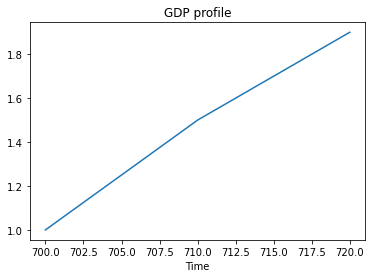

In [2775]:
gdp_profile = pd.Series([1.0, 1.5, 1.9], index=pd.Index(model_horizon, name="Time"))
gdp_profile.plot(title="GDP profile")

First we establish demand. Let's assume

- 40 million people in [300 AC](https://atlasoficeandfireblog.wordpress.com/2016/03/06/the-population-of-the-seven-kingdoms/)
- similar population growth to Earth in the same time frame [(~factor of 12)](https://en.wikipedia.org/wiki/World_population_estimates)
- a per capita demand for electricity of 1000 kWh
- and 8760 hours in a year (of course!)

Then we can add the demand parameter

Note present day: [~72000 GWh in Austria](https://www.iea.org/statistics/?country=AUSTRIA&year=2016&category=Energy%20consumption&indicator=undefined&mode=chart&dataTable=INDICATORS) with population [~8.7M](http://www.austria.org/population/) which is ~8300 kWh per capita

In [2776]:
demand_per_year = 40 * 12 * 1000 / 8760

light_demand = pd.DataFrame(
    {
        "node": country,
        "commodity": "light",
        "level": "useful",
        "year": model_horizon,
        "time": "year",
        "value": (demand_per_year * gdp_profile).round(),
        "unit": "GWa",
    }
)

In [2777]:
light_demand

,node,commodity,level,year,time,value,unit
Time,,,,,,,
700,Westeros,light,useful,700,year,55.0,GWa
710,Westeros,light,useful,710,year,82.0,GWa
720,Westeros,light,useful,720,year,104.0,GWa


In [2778]:
# We use `add_par` for adding data to a MESSAGEix parameter
scenario.add_par("demand", light_demand)

In [2779]:
year_df = scenario.vintage_and_active_years()
vintage_years, act_years = year_df["year_vtg"], year_df["year_act"]

# Some common values to be used for both the "input" and "output" parameters
base = dict(
    node_loc=country,
    year_vtg=vintage_years,
    year_act=act_years,
    mode="standard",
    time="year",
    unit="-",
)

# Use the message_ix utility function make_df() to create a base data frame for
# different "input" parameter values
base_input = make_df("input", **base, node_origin=country, time_origin="year")

# Create a base data frame for different "output" parameter values
base_output = make_df("output", **base, node_dest=country, time_dest="year")

### added the LED technology with a 10% higher efficiency than the light bulb:
This is a tricky assumption as it directly correlates to the total amount of consumed electricity. If I were to make the LED 5-times more efficient than the light bulb, the model will always buy only LEDs because then only 20% of the total electricity will be used which results in ludacrous prices for LEDs if I want the model output to be the same.

In [2780]:
# Extend `base_output` by filling in some of the other columns, using the
# pandas.DataFrame.assign() method
bulb_out = base_output.assign(
    technology="bulb", 
    commodity="light", 
    level="useful", 
    value=1.0
)
scenario.add_par("output", bulb_out)

LED_out = base_output.assign(
    technology="LED", 
    commodity="light", 
    level="useful", 
    value=1.1  # efficiency raised by 10 %
)
scenario.add_par("output", LED_out)

bulb_in = base_input.assign(
    technology="bulb", 
    commodity="electricity", 
    level="final", 
    value=1.0
)
scenario.add_par("input", bulb_in)

LED_in = base_input.assign(
    technology="LED", 
    commodity="electricity", 
    level="final", 
    value=1.0
)
scenario.add_par("input", LED_in)

In [2781]:
grid_efficiency = 0.9
grid_out = base_output.assign(
    technology="grid",
    commodity="electricity",
    level="final",
    value=grid_efficiency,
)
scenario.add_par("output", grid_out)

grid_in = base_input.assign(
    technology="grid", 
    commodity="electricity", 
    level="secondary", 
    value=1.0
)
scenario.add_par("input", grid_in)

In [2782]:
coal_out = base_output.assign(
    technology="coal_ppl",
    commodity="electricity",
    level="secondary",
    value=1.0,
    unit="GWa",
)
scenario.add_par("output", coal_out)

wind_out = base_output.assign(
    technology="wind_ppl",
    commodity="electricity",
    level="secondary",
    value=1.0,
    unit="GWa",
)
scenario.add_par("output", wind_out)

### LED has the same capacity factor as the bulb as it is also 100% available if installed

In [2783]:
capacity_factor = {
    "coal_ppl": 1,
    "wind_ppl": 0.36,
    "bulb": 1,
    "LED": 1
}

for tec, val in capacity_factor.items():
    df = make_df(
        "capacity_factor",
        node_loc=country,
        year_vtg=vintage_years,
        year_act=act_years,
        time="year",
        unit="-",
        technology=tec,
        value=val,
    )
    scenario.add_par("capacity_factor", df)

### LED has a 4 times higher lifetime than the bulb

In [2784]:
lifetime = {
    "coal_ppl": 20,
    "wind_ppl": 20,
    "bulb": 1,
    "LED": 4  # lifetime of the LED added
}

for tec, val in lifetime.items():
    df = make_df(
        "technical_lifetime",
        node_loc=country,
        year_vtg=model_horizon,
        unit="y",
        technology=tec,
        value=val,
    )
    scenario.add_par("technical_lifetime", df)

#### Technological Diffusion and Contraction


In [2785]:
growth_technologies = [
    "coal_ppl",
    "wind_ppl",
]

for tec in growth_technologies:
    df = make_df(
        "growth_activity_up",
        node_loc=country,
        year_act=model_horizon,
        time="year",
        unit="-",
        technology=tec,
        value=0.1,
    )
    scenario.add_par("growth_activity_up", df)

In [2786]:
light_demand

,node,commodity,level,year,time,value,unit
Time,,,,,,,
700,Westeros,light,useful,700,year,55.0,GWa
710,Westeros,light,useful,710,year,82.0,GWa
720,Westeros,light,useful,720,year,104.0,GWa


In [2787]:
historic_demand = 0.5 * demand_per_year
historic_generation = historic_demand / grid_efficiency
coal_fraction = 0.6

### Historic demand was covered by light bulbs only

In [2788]:
old_activity = {
    "coal_ppl": coal_fraction * historic_generation,
    "wind_ppl": (1 - coal_fraction) * historic_generation,
    "bulb": historic_demand,  # added the bulbs to "old_activity"
    "LED": 0
}

for tec, val in old_activity.items():
    df = make_df(
        "historical_activity",
        node_loc=country,
        year_act=history,
        mode="standard",
        time="year",
        unit="GWa",
        technology=tec,
        value=val,
    )
    scenario.add_par("historical_activity", df)

In [2789]:
for tec in old_activity:
    value = old_activity[tec] / (1 * 10 * capacity_factor[tec])
    df = make_df(
        "historical_new_capacity",
        node_loc=country,
        year_vtg=history,
        unit="GWa",
        technology=tec,
        value=value,
    )
    scenario.add_par("historical_new_capacity", df)

In [2790]:
scenario.add_par("interestrate", model_horizon, value=0.05, unit="-")

### I added the LED with higher investment costs than bulb:

LED costs 300 USD/kW.  I chose this value so the LED will not be chosen in the baseline scenario. If the LED was cheaper (eg. 200USD/kW it is already better than the bulb because of the efficiency increase. When taking the lifetime into account the LED is now also more expensive than the wind and coal power plants which will be visible later in the results.

In [2791]:
# Add a new unit for ixmp to recognize as valid
mp.add_unit("USD/kW")

# in $ / kW (specific investment cost)
costs = {
    "coal_ppl": 500,
    "wind_ppl": 1500,
    "bulb": 5,
    "LED": 300,  # a lot more expensive than bulb
}

for tec, val in costs.items():
    df = make_df(
        "inv_cost",
        node_loc=country,
        year_vtg=model_horizon,
        unit="USD/kW",
        technology=tec,
        value=val,
    )
    scenario.add_par("inv_cost", df)

In [2792]:
# in $ / kW / year (every year a fixed quantity is destinated to cover part of the O&M costs
# based on the size of the plant, e.g. lightning, labor, scheduled maintenance, etc.)

costs = {
    "coal_ppl": 30,
    "wind_ppl": 10,
}

for tec, val in costs.items():
    df = make_df(
        "fix_cost",
        node_loc=country,
        year_vtg=vintage_years,
        year_act=act_years,
        unit="USD/kWa",
        technology=tec,
        value=val,
    )
    scenario.add_par("fix_cost", df)

In [2793]:
costs = {
    "coal_ppl": 30,
    "grid": 50,
}

for tec, val in costs.items():
    df = make_df(
        "var_cost",
        node_loc=country,
        year_vtg=vintage_years,
        year_act=act_years,
        mode="standard",
        time="year",
        unit="USD/kWa",
        technology=tec,
        value=val,
    )
    scenario.add_par("var_cost", df)

#### Solve model

In [2794]:
from message_ix import log

log.info(f"version number before commit(): {scenario.version}")

scenario.commit(comment="basic model of Westeros electrification")

log.info(f"version number after commit(): {scenario.version}")

In [2795]:
scenario.set_as_default()

In [2796]:
scenario.solve()

### show that the model has the same result as in the initial westeros_baseline scenario:
The objective function in the initial scenario returned: 173795.09375

In [2797]:
scenario.var("OBJ")["lvl"]

173795.09375

In [2798]:
# check if the result changed in comparison to the initial scenario without LED:
assert 173795.09375 == scenario.var("OBJ")["lvl"]

#### The results did not change

## 2) "Investigate under which carbon price the LED technology becomes economically viable":

reload the scenario created before, but unsolved:

In [2799]:
base = message_ix.Scenario(mp, model="Westeros Electrified", scenario="baseline")
scenario_2 = base.clone("Westeros Electrified", 
                        "co2_price",
                        "introduction of co2 prices", 
                        keep_solution=False)
scenario_2.check_out()

## Introducing Emissions

In [2800]:
# First we introduce the emission of CO2 and the emission category GHG
scenario_2.add_set("emission", "CO2")
scenario_2.add_cat("emission", "GHG", "CO2")
scenario_2.add_par("emission_factor", scenario_2.par("emission_factor"))

# Then we add new units to the model library (needed only once)
mp.add_unit("tCO2/kWa")

# add CO2 emissions to the coal powerplant
emission_factor = make_df(
    "emission_factor",
    node_loc=country,
    year_vtg=vintage_years,
    year_act=act_years,
    mode="standard",
    unit="tCO2/kWa",
    technology="coal_ppl",
    emission="CO2",
    value=7.4,
)
scenario_2.add_par("emission_factor", emission_factor)

### adding the CO2 tax

In [2801]:
prices = [10, 20, 30]
emission_prices = pd.DataFrame(index=[700, 710, 720], data=prices, columns=["lvl"])

scenario_2.add_set("type_year", [700, 710, 720])

# add units
mp.add_unit("USD/tCO2")

tax_emission = make_df(
    "tax_emission",
    node="Westeros",
    type_year=[700, 710, 720],
    type_tec="all",
    unit="USD/tCO2",
    type_emission="GHG",
    value=emission_prices.lvl,
)
scenario_2.add_par("tax_emission", tax_emission)
scenario_2.par("tax_emission")

,node,type_emission,type_tec,type_year,value,unit
0,Westeros,GHG,all,700,10.0,USD/tCO2
1,Westeros,GHG,all,710,20.0,USD/tCO2
2,Westeros,GHG,all,720,30.0,USD/tCO2


In [2802]:
scenario_2.commit(comment="Introducing co2 price")
scenario_2.set_as_default()
scenario_2.solve()
print(scenario_2.var("OBJ")["lvl"])

337948.4375


#### put the code above in a single function to re-run it in one call so the CO2-prices can be changed easily:

In [2803]:
def run_scenario(prices):
    base = message_ix.Scenario(mp, model="Westeros Electrified", scenario="baseline")
    scenario_2 = base.clone("Westeros Electrified", 
                            "co2_price_2",
                            "introduction of co2 prices", 
                            keep_solution=False)
    scenario_2.check_out()
    # First we introduce the emission of CO2 and the emission category GHG
    scenario_2.add_set("emission", "CO2")
    scenario_2.add_cat("emission", "GHG", "CO2")
    scenario_2.add_par("emission_factor", scenario_2.par("emission_factor"))

    # Then we add new units to the model library (needed only once)
    mp.add_unit("tCO2/kWa")

    # add CO2 emissions to the coal powerplant
    emission_factor = make_df(
        "emission_factor",
        node_loc=country,
        year_vtg=vintage_years,
        year_act=act_years,
        mode="standard",
        unit="tCO2/kWa",
        technology="coal_ppl",
        emission="CO2",
        value=7.4,
    )
    scenario_2.add_par("emission_factor", emission_factor)
    
    # specify CO2 prices for each decade
    emission_prices = pd.DataFrame(index=[700, 710, 720], data=prices, columns=["lvl"])

    scenario_2.add_set("type_year", [700, 710, 720])

    # add units
    mp.add_unit("USD/tCO2")

    tax_emission = make_df(
        "tax_emission",
        node="Westeros",
        type_year=[700, 710, 720],
        type_tec="all",
        unit="USD/tCO2",
        type_emission="GHG",
        value=emission_prices.lvl,
    )
    scenario_2.add_par("tax_emission", tax_emission)
    scenario_2.par("tax_emission")
    
    # solve the model:
    scenario_2.commit(comment="Introducing co2 price")
    scenario_2.set_as_default()
    scenario_2.solve()
    print(scenario_2.var("OBJ")["lvl"])
    
    return scenario_2

#### prepare for plots

In [2804]:
rep = Reporter.from_scenario(scenario_2)
prepare_plots(rep)

#### The LED is not used with these CO2 prices (10, 20, 30 USD/tCO2) yet

<AxesSubplot:title={'center':'Westeros Energy System Activity'}, xlabel='Year', ylabel='GWa'>

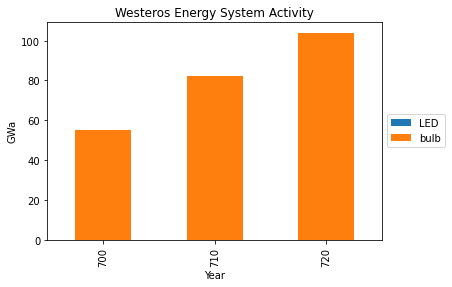

In [2805]:
# show LED results:
rep.set_filters(t=["bulb", "LED"])
rep.get("plot activity")

#### However the coal power plants are reduced significantly with the CO2 price (10, 20, 30 USD/tCO2) is in place

<AxesSubplot:title={'center':'Westeros Energy System Activity'}, xlabel='Year', ylabel='GWa'>

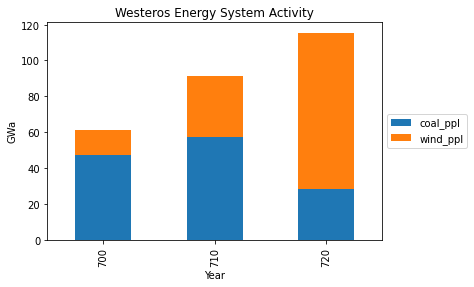

In [2806]:
rep = Reporter.from_scenario(scenario_2)
prepare_plots(rep)
rep.set_filters(t=["coal_ppl", "wind_ppl"])
rep.get("plot activity")

#### I increased the prices significantly until I saw that the LED will be used:

In [2807]:
prices = [60, 70, 80]  # set prices to 60, 70, and 80 USD/tCO2
new_scenario = run_scenario(prices)

463864.90625


In [2808]:
rep = Reporter.from_scenario(new_scenario)
prepare_plots(rep)

#### With these CO2 prices the coal power plant is almost completly phased out in the second decade and phased out in the last decade:

<AxesSubplot:title={'center':'Westeros Energy System Activity'}, xlabel='Year', ylabel='GWa'>

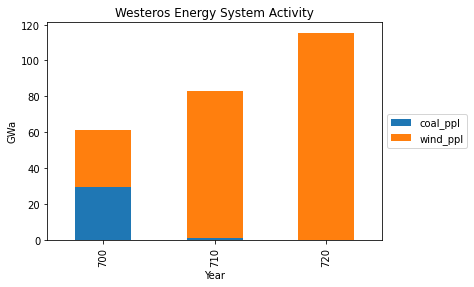

In [2809]:
rep.set_filters(t=["coal_ppl", "wind_ppl"])
rep.get("plot activity")

#### We can also observe that only wind power plants are being built after 700. 

<AxesSubplot:title={'center':'Westeros Energy System New Capacity'}, xlabel='Year', ylabel='GWa'>

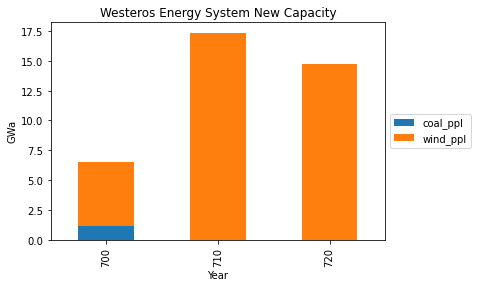

In [2810]:
rep.get("plot new capacity")

#### At the same time LEDs become viable in the second decade. The CO2 price in the second decade rises from 60to 70 USD/tCO2. I assume that the price barrier for LED to become economically is between 50 and 60 USD/tCO2.

<AxesSubplot:title={'center':'Westeros Energy System Activity'}, xlabel='Year', ylabel='GWa'>

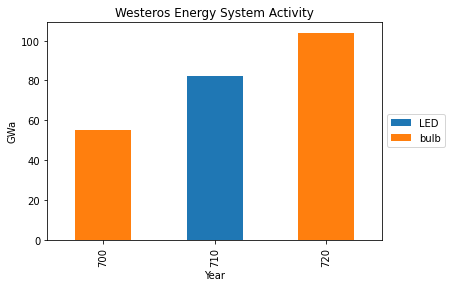

In [2811]:
rep = Reporter.from_scenario(new_scenario)
prepare_plots(rep)
rep.set_filters(t=["bulb", "LED"])
rep.get("plot activity")

#### Because of the higher efficiency + lifetime of the LED, the system has to install much less capacity

<AxesSubplot:title={'center':'Westeros Energy System New Capacity'}, xlabel='Year', ylabel='GWa'>

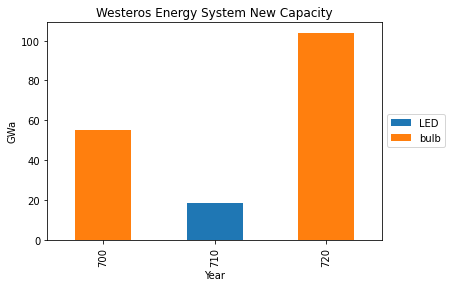

In [2812]:
rep.get("plot new capacity")

### If we re-run the scenario with 70USD/tCO2 the LED will be used in the first decade as well:

In [2813]:
prices = [70, 70, 70]  # same price in all decades
new_scenario = run_scenario(prices)

478485.4375


In [2814]:
rep = Reporter.from_scenario(new_scenario)
prepare_plots(rep)

<AxesSubplot:title={'center':'Westeros Energy System Activity'}, xlabel='Year', ylabel='GWa'>

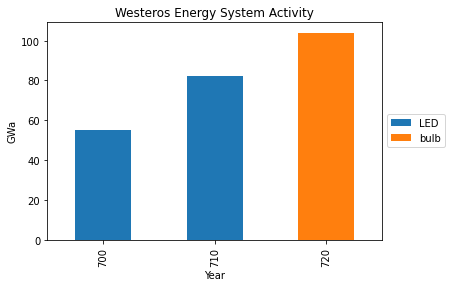

In [2815]:
rep.set_filters(t=["bulb", "LED"])
rep.get("plot activity")

#### The model never chooses to install LEDs in the last decade because  in this set up buying LEDs is more expensive than building more wind parks. In the last decade coal is completly phased out, thus the electricity price is much cheaper which makes the LED uneconomically compared to the light bulb.

<AxesSubplot:title={'center':'Westeros Energy System Prices'}, xlabel='Year', ylabel='¢/kW·h'>

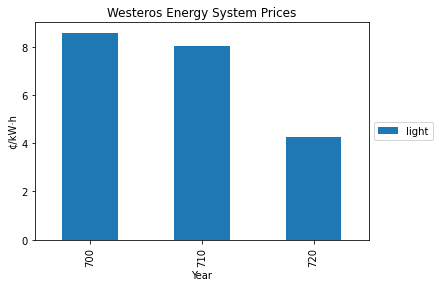

In [2816]:
rep.set_filters(c=["light"])
rep.get("plot prices")

## 3) "Assume different maximum diffusion rates for this new technology and compare the share of electricity from coal and wind depending on the diffusion rates"

Clone the last model with a steady CO2 price of 70 USD/tCO2:

In [2817]:
def run_diffusion_constraints(max_growth, inital_activity):
    base = message_ix.Scenario(mp, model="Westeros Electrified", scenario="co2_price_2")
    scenario_3 = base.clone("Westeros Electrified", 
                            "LED_diffusion",
                            keep_solution=False)


    scenario_3.check_out()
    
    # define the diffusion constraint
    technologies = {"LED": max_growth, "bulb": 1}
    
    # give the LED an initial_activity_up (otherwise LEDs are ignored)
    df_led_initial_activity_up = make_df(
        "initial_activity_up",
            node_loc=country,
            year_act=model_horizon,
            time="year",
            unit="-",
            technology="LED",
            value=inital_activity,
        )
    scenario_3.add_par("initial_activity_up", df_led_initial_activity_up)
    
    # set the diffusion constraint
    for tec, diffusion in technologies.items():
        df = make_df(
            "growth_activity_up",
            node_loc=country,
            year_act=model_horizon,
            time="year",
            unit="-",
            technology=tec,
            value=diffusion,
        )
        scenario_3.add_par("growth_activity_up", df)
    
    # solve model
    scenario_3.commit(comment="Introducing diffusion rate")
    scenario_3.set_as_default()
    scenario_3.solve()
    print(scenario_3.var("OBJ")["lvl"])
    
    return scenario_3

### define the diffusion constraint:

The initial activity up for the LED is set to 10%. This value is not changed in the following because the maximal growth in capacity refers to this value.

In [2818]:
initial_LED_activity = 0.1

In [2819]:
maximal_diffusion_LED = 0.1  # 10%
scenario_3 = run_diffusion_constraints(maximal_diffusion_LED, initial_LED_activity)

480756.4375


In [2820]:
rep = Reporter.from_scenario(scenario_3)
prepare_plots(rep)

#### With 10% growth in activity for the LED, the technology does not really come into play:

<AxesSubplot:title={'center':'Westeros Energy System Activity'}, xlabel='Year', ylabel='GWa'>

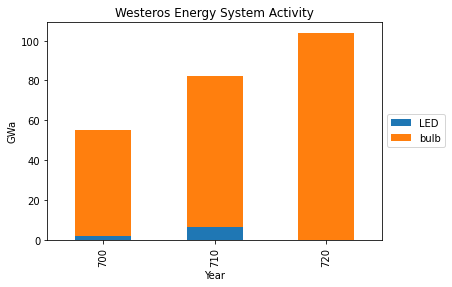

In [2821]:
rep.set_filters(t=["bulb", "LED"])
rep.get("plot activity")

The coal power plant is more active with the LED being constrained to a 10% capacity growth. Wind power plants can not be built fast enough therefore coal has to provide the additional electricity.

<AxesSubplot:title={'center':'Westeros Energy System Activity'}, xlabel='Year', ylabel='GWa'>

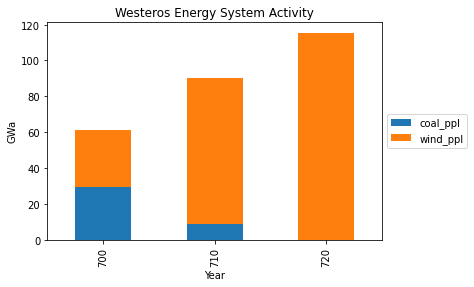

In [2822]:
rep.set_filters(t=["coal_ppl", "wind_ppl"])
rep.get("plot activity")

Setting the growth capacity up for LED to **50%** leads to the LED being active for ~99% in 710. In 700 only a quarter of the light is provided by LED because the growth capacity of 50% per year compared to the initial year is not large enough.

In [2823]:
maximal_diffusion_LED = 0.5  # 50%
scenario_4 = run_diffusion_constraints(maximal_diffusion_LED, initial_LED_activity)

480227.25


In [2824]:
rep = Reporter.from_scenario(scenario_4)
prepare_plots(rep)

<AxesSubplot:title={'center':'Westeros Energy System Activity'}, xlabel='Year', ylabel='GWa'>

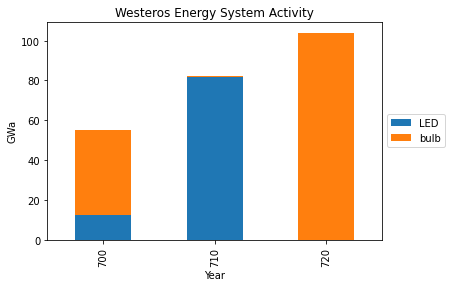

In [2825]:
rep.set_filters(t=["bulb", "LED"])
rep.get("plot activity")

With the growth constraint set to 50% the coal power plant activity is only a little bit higher in 700 than without growth constraints. 

<AxesSubplot:title={'center':'Westeros Energy System Activity'}, xlabel='Year', ylabel='GWa'>

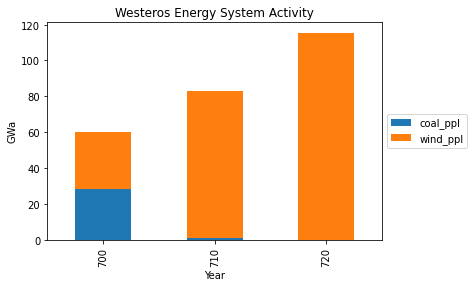

In [2826]:
rep.set_filters(t=["coal_ppl", "wind_ppl"])
rep.get("plot activity")

Setting the growth capacity to **100%** leads to a total usage of LED in 700. In 710 there is still a very small part covered by bulbs. The constraint to this lies in the 10% initial activity up assumption. Coal and wind power behave in the same way as without growth constraints which is expected.

In [2827]:
maximal_diffusion_LED = 1  # 100%
scenario_5 = run_diffusion_constraints(maximal_diffusion_LED, initial_LED_activity)

478485.5625


In [2828]:
rep = Reporter.from_scenario(scenario_5)
prepare_plots(rep)

<AxesSubplot:title={'center':'Westeros Energy System Activity'}, xlabel='Year', ylabel='GWa'>

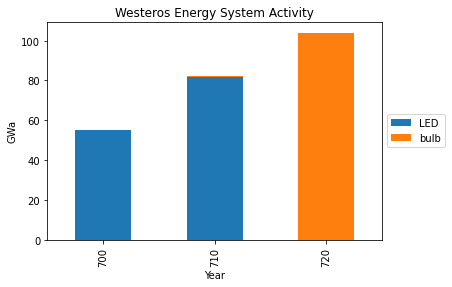

In [2829]:
rep.set_filters(t=["bulb", "LED"])
rep.get("plot activity")

<AxesSubplot:title={'center':'Westeros Energy System Activity'}, xlabel='Year', ylabel='GWa'>

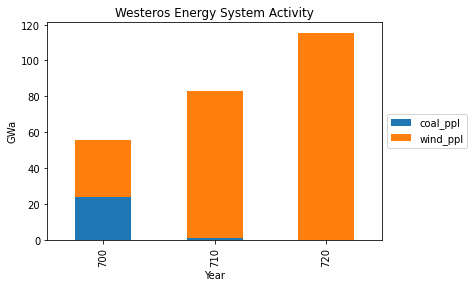

In [2830]:
rep.set_filters(t=["coal_ppl", "wind_ppl"])
rep.get("plot activity")

## Conclusion

When implementing the LED the efficiency of the technology has an immense impact on the results as it directly correlates to the overal need of electricity. In order to "force" the model to still use light bulbs the prices for LED must be extremely high.

With rising CO2 prices the model first installs Windpower instead of buying LED which is related to the high investment costs, set for LED. When CO2 prices rise above a certain threshold and the system can not provide enough energy solely by wind, LEDs are being bought to reduce the demand. The lower demand is then covered entirely by wind power. In the last decade the model is able to provide 100% of the electricity with wind power plants, thus only bulbs are used in 720. 

When implementing diffusion constraints to the LED technology the coal power plant has to be more active if wind power can not be inreased sufficiently to provide enough electricity. With the existing CO2 prices in this scenario wind power is built as much as possible. Therefore we don't see a change in wind capacity depending on the diffusion rate of LED. 

In [2831]:
mp.close_db()

## References

[1] Daniel Huppmann, Matthew Gidden, Oliver Fricko, Peter Kolp, Clara Orthofer, Michael Pimmer, Nikolay Kushin, Adriano Vinca, Alessio Mastrucci, Keywan Riahi, and Volker Krey.
“The MESSAGEix Integrated Assessment Model and the ix modeling platform”.
Environmental Modelling & Software 112:143-156, 2019.
doi: 10.1016/j.envsoft.2018.11.012 [Titel anhand dieser DOI in Citavi-Projekt übernehmen]
electronic pre-print available at pure.iiasa.ac.at/15157/.


## License

   [<img style="float: right;" src="https://img.shields.io/badge/License-Apache%202.0-blue.svg">](https://opensource.org/licenses/Apache-2.0)

   Copyright 2022 Philipp Mascherbauer

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

     http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.